# 시스템 품질 변화로 인한 사용자 불편 예지 AI 경진대회 - EDA #1

* https://dacon.io/competitions/official/235687/overview/

# 1. Library Import

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

PATH = '../input/'

In [3]:
import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/.DS_Store
../input/test_quality_data.csv
../input/test_err_data.csv
../input/data.zip
../input/train_problem_data.csv
../input/train_quality_data.csv
../input/train_err_data.csv
../input/sample_submission.csv


## Load Dataset

주최 측에서 제공한 데이터를 확인 & Load 합니다.

In [4]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_quality  = pd.read_csv(PATH+'train_quality_data.csv')
train_problem  = pd.read_csv(PATH+'train_problem_data.csv')

test_err  = pd.read_csv(PATH+'test_err_data.csv')
test_quality  = pd.read_csv(PATH+'test_quality_data.csv')

## 데이터 이해하기

1. 데이터의 사이즈는? 모델 학습에 적합한 형태인가?
2. Train/Test는 어떻게 분리되어 있는가?
3. Missing Value는?
4. Target Variable의 분포는?
5. 간단히 데이터 살펴보기
6. 데이터의 특이한/주목해야할 부분은?

### 1. 데이터의 사이즈는?

In [5]:
# train_err
print("-- Size -- ")
print(f"train_err : {train_err.shape}")
print(f"test_err  : {test_err.shape}")

# train_quality
print("-- Size -- ")
print(f"train_quality : {train_quality.shape}")
print(f"test_quality  : {test_quality.shape}")

-- Size -- 
train_err : (16554663, 6)
test_err  : (16532648, 6)
-- Size -- 
train_quality : (828624, 16)
test_quality  : (747972, 16)


In [6]:
# Train-set에만 있는 칼럼은?
print(train_err.columns.difference( test_err.columns ))

# Train-set에만 있는 칼럼은?
print(train_quality.columns.difference( test_quality.columns ))

Index([], dtype='object')
Index([], dtype='object')


### 2. Train/Test는 어떻게 분리되어 있는가?

In [9]:
# Train/Test-set은 어떻게 분리되었을까?
display(train_err.head(2))
display(train_err.tail(2))
display(test_err.head(2))
display(test_err.tail(2))

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1


,user_id,time,model_nm,fwver,errtype,errcode
16554661,24999,20201130172631,model_3,05.15.2138,4,0
16554662,24999,20201130210625,model_3,05.15.2138,15,1


,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2


,user_id,time,model_nm,fwver,errtype,errcode
16532646,44998,20201130212259,model_1,04.16.3553,16,1
16532647,44998,20201130212316,model_1,04.16.3553,31,0


### id에 차이가 있는가?

In [10]:
# train_err / test_err의 user_id는?
display("train_err", train_err['user_id'].agg(['min','max']) )
print(f'Size : {len(train_err)}')

print('='* 80)

display("test_err",  test_err['user_id'].agg(['min','max']) )
print(f'Size : {len(test_err)}')

'train_err'

min    10000
max    24999
Name: user_id, dtype: int64

Size : 16554663


'test_err'

min    30000
max    44998
Name: user_id, dtype: int64

Size : 16532648


In [11]:
# train_quality / test_quality 의 user_id는?
display("train_quality", train_quality['user_id'].agg(['min','max']) )
print(f'Size : {len(train_quality)}')

print('='* 80)
display("test_quality",  test_quality['user_id'].agg(['min','max']) )
print(f'Size : {len(test_quality)}')

'train_quality'

min    10000
max    24997
Name: user_id, dtype: int64

Size : 828624


'test_quality'

min    30000
max    44997
Name: user_id, dtype: int64

Size : 747972


### time 에 차이가 있는가?

In [12]:
# train_err / test_err 의 time는?
display("train_err",  train_err['time'].agg(['min','max']) )
print(f'Size : {len(train_err)}')

print('='* 80)

display("test_err",  test_err['time'].agg(['min','max']) )
print(f'Size : {len(test_err)}')

'train_err'

min    20201031235959
max    20201202185152
Name: time, dtype: int64

Size : 16554663


'test_err'

min    20201031235959
max    20201214120118
Name: time, dtype: int64

Size : 16532648


In [14]:
# train_quality / test_quality 의 date는?
display("train_quality",  train_quality['time'].agg(['min','max']) )
print(f'Size : {len(train_quality)}')

print('='* 80)

display("test_quality",  test_quality['time'].agg(['min','max']) )
print(f'Size : {len(test_quality)}')

'train_quality'

min    20201031235000
max    20201130234000
Name: time, dtype: int64

Size : 828624


'test_quality'

min    20201031235000
max    20201130234000
Name: time, dtype: int64

Size : 747972


In [59]:
#%%time
#train_err['datetime'] = train_err.time.apply(pd.to_datetime)
#test_err['datetime'] = test_err.time.apply(pd.to_datetime)

#train_quality['datetime'] = train_quality.time.apply(pd.to_datetime)
#test_quality['datetime'] = test_quality.time.apply(pd.to_datetime)

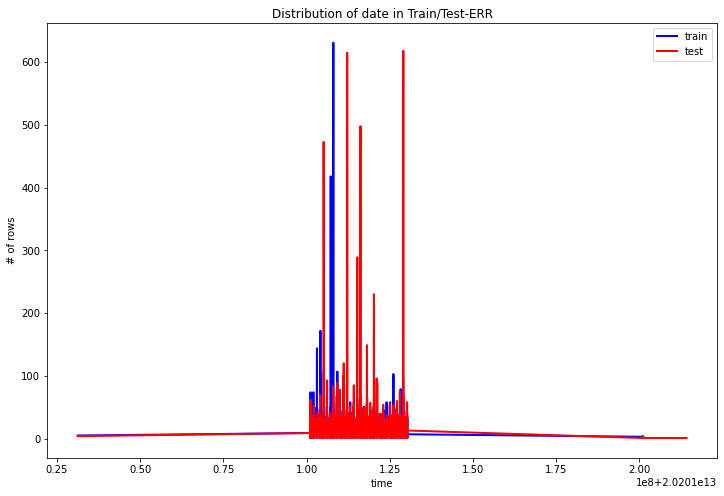

In [21]:
# train_err / test_err - time
# Figure을 정의
plt.figure(figsize = (12,8))

# Train/Test-set 각각에서 특정 date가 몇 번 등장했는지 시각화 시킴
train_err['time'].value_counts().sort_index().plot(color='b', lw=2, label='train')
test_err['time'].value_counts().sort_index().plot(color='r',  lw=2, label='test')

plt.legend()
plt.xlabel("time")
plt.ylabel("# of rows")
plt.title("Distribution of date in Train/Test-ERR");

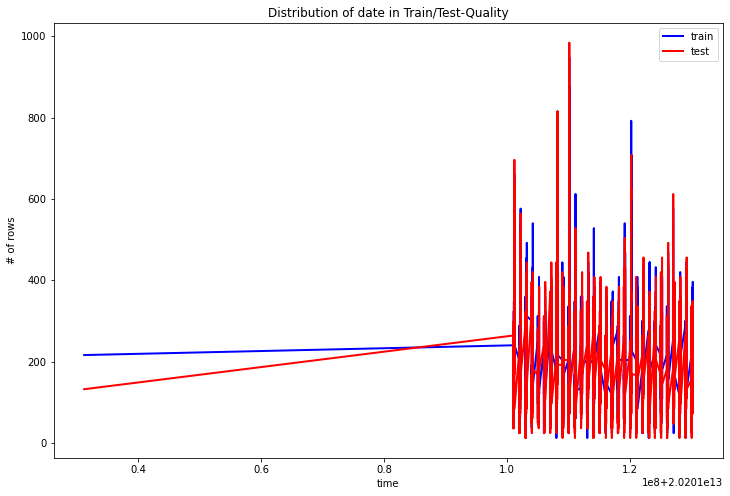

In [20]:
# train_quality / test_quality - time
# Figure을 정의
plt.figure(figsize = (12,8))

# Train/Test-set 각각에서 특정 date가 몇 번 등장했는지 시각화 시킴
train_quality['time'].value_counts().sort_index().plot(color='b', lw=2, label='train')
test_quality['time'].value_counts().sort_index().plot(color='r',  lw=2, label='test')

plt.legend()
plt.xlabel("time")
plt.ylabel("# of rows")
plt.title("Distribution of date in Train/Test-Quality");

### 피쳐 별로 train / test 비교

#### user_id

In [55]:
# Train/Test-set의 고유한 user_id 구함.
train_err_errtype_set = set(train_err['user_id'])
test_err_errtype_set  = set(test_err['user_id'])


# Train/Test-set 고유한 user_id 개수를 구함.
print(f"Train-set에 있는 고유한 user_id 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 user_id 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 user_id 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 user_id 개수 : {len(common_errtype)}")

# Train-set에만 있는 user_id 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 user_id 총 { len(only_train_err_errtype) }개 입니다.")
#print(f"Train-set에만 있는 user_id : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 user_id 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 user_id 총 { len(only_test_err_errtype) }개 입니다.")
#print(f"Test-set에만 있는 user_id : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 user_id 개수 : 15000
Test-set에 있는 고유한 user_id 개수 : 14998
Train/Test-set에 공통으로 포함되어 있는 user_id 개수 : 0
Train-set에만 있는 user_id 총 15000개 입니다.
Test-set에만 있는 user_id 총 14998개 입니다.


#### model_nm

In [52]:
# Train/Test-set의 고유한 model_nm 구함.
train_err_errtype_set = set(train_err['model_nm'])
test_err_errtype_set  = set(test_err['model_nm'])


# Train/Test-set 고유한 model_nm 개수를 구함.
print(f"Train-set에 있는 고유한 model_nm 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 model_nm 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 model_nm 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 model_nm 개수 : {len(common_errtype)}")

# Train-set에만 있는 model_nm 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 model_nm 총 { len(only_train_err_errtype) }개 입니다.")
print(f"Train-set에만 있는 model_nm : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 model_nm 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 model_nm 총 { len(only_test_err_errtype) }개 입니다.")
print(f"Test-set에만 있는 model_nm : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 model_nm 개수 : 9
Test-set에 있는 고유한 model_nm 개수 : 9
Train/Test-set에 공통으로 포함되어 있는 model_nm 개수 : 9
Train-set에만 있는 model_nm 총 0개 입니다.
Train-set에만 있는 model_nm : []
Test-set에만 있는 model_nm 총 0개 입니다.
Test-set에만 있는 model_nm : []


#### fwver

In [51]:
# Train/Test-set의 고유한 fwver 구함.
train_err_errtype_set = set(train_err['fwver'])
test_err_errtype_set  = set(test_err['fwver'])


# Train/Test-set 고유한 errtype의 개수를 구함.
print(f"Train-set에 있는 고유한 fwver 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 fwver 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 errtype를 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 fwver 개수 : {len(common_errtype)}")

# Train-set에만 있는 errtype를 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 fwver 총 { len(only_train_err_errtype) }개 입니다.")
print(f"Train-set에만 있는 fwver : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 errtype를 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 fwver 총 { len(only_test_err_errtype) }개 입니다.")
print(f"Test-set에만 있는 fwver : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 fwver 개수 : 37
Test-set에 있는 고유한 fwver 개수 : 40
Train/Test-set에 공통으로 포함되어 있는 fwver 개수 : 31
Train-set에만 있는 fwver 총 6개 입니다.
Train-set에만 있는 fwver : ['04.16.2641', '04.16.3345', '04.22.1442', '04.33.1095', '05.15.2090', '05.15.2122']
Test-set에만 있는 fwver 총 9개 입니다.
Test-set에만 있는 fwver : ['04.22.1170', '04.22.1448', '04.22.1478', '04.22.1608', '04.22.1772', '04.73.2569', '04.73.2577', '10.22.1770', '10.22.1780']


#### errtype

In [50]:
# Train/Test-set의 고유한 errtype 구함.
train_err_errtype_set = set(train_err['errtype'])
test_err_errtype_set  = set(test_err['errtype'])


# Train/Test-set 고유한 errtype의 개수를 구함.
print(f"Train-set에 있는 고유한 errtype의 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 errtype의 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 errtype를 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 errtype 개수 : {len(common_errtype)}")

# Train-set에만 있는 errtype를 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 errtype는 총 { len(only_train_err_errtype) }개 입니다.")
print(f"Train-set에만 있는 errtype는 : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 errtype를 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 errtype는 총 { len(only_test_err_errtype) }개 입니다.")
print(f"Test-set에만 있는 errtype는 : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 errtype의 개수 : 41
Test-set에 있는 고유한 errtype의 개수 : 41
Train/Test-set에 공통으로 포함되어 있는 errtype 개수 : 41
Train-set에만 있는 errtype는 총 0개 입니다.
Train-set에만 있는 errtype는 : []
Test-set에만 있는 errtype는 총 0개 입니다.
Test-set에만 있는 errtype는 : []


#### errcode

In [57]:
# Train/Test-set의 고유한 errcode 구함.
train_err_errtype_set = set(train_err['errcode'])
test_err_errtype_set  = set(test_err['errcode'])


# Train/Test-set 고유한 errcode 개수를 구함.
print(f"Train-set에 있는 고유한 errcode 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 errcode 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 errcode 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 errcode 개수 : {len(common_errtype)}")

# Train-set에만 있는 errcode 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 errcode 총 { len(only_train_err_errtype) }개 입니다.")
#print(f"Train-set에만 있는 errcode : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 errcode 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 errcode 총 { len(only_test_err_errtype) }개 입니다.")
#print(f"Test-set에만 있는 errcode : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 errcode 개수 : 2806
Test-set에 있는 고유한 errcode 개수 : 2956
Train/Test-set에 공통으로 포함되어 있는 errcode 개수 : 1408
Train-set에만 있는 errcode 총 1398개 입니다.
Test-set에만 있는 errcode 총 1548개 입니다.


### 3. Missing Value는 존재하는가?


<AxesSubplot:>

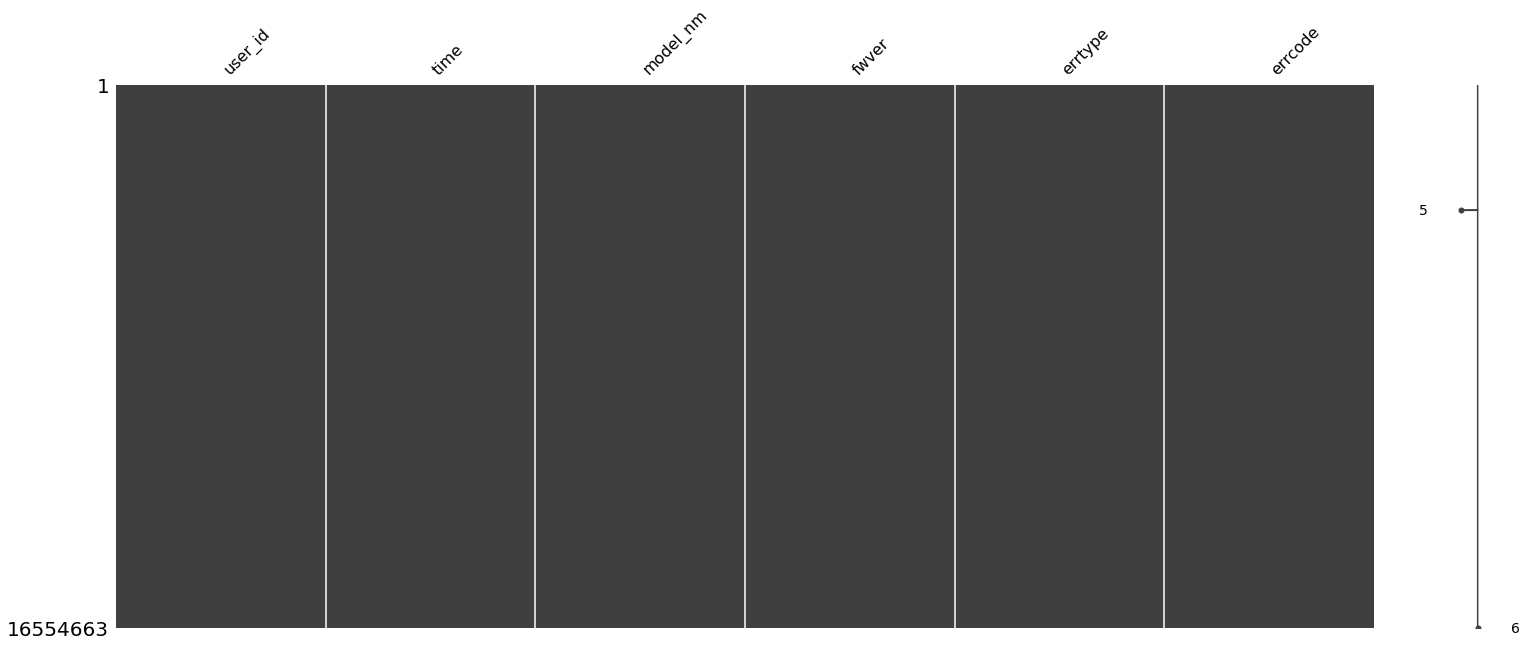

In [29]:
import missingno as msno

# Missing Values
msno.matrix(train_err)

<AxesSubplot:>

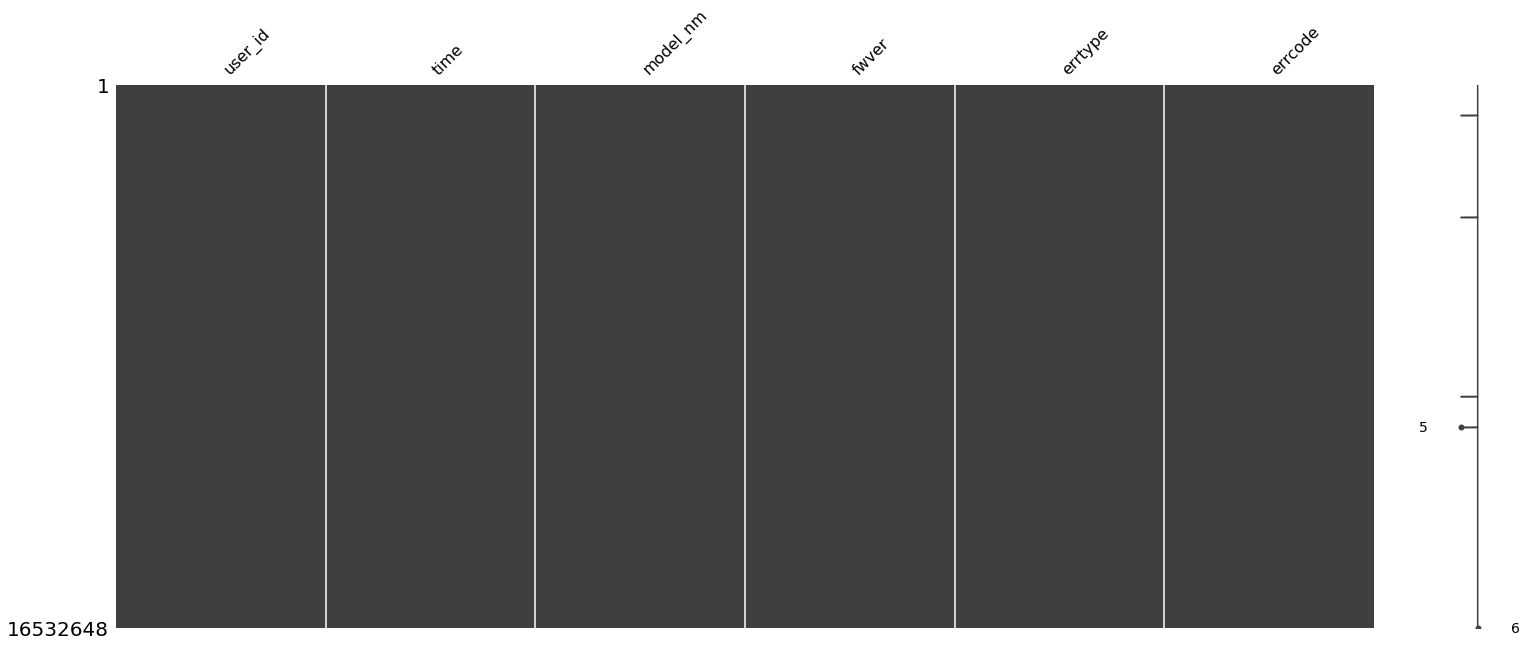

In [33]:
import missingno as msno

# Missing Values
msno.matrix(test_err)

<AxesSubplot:>

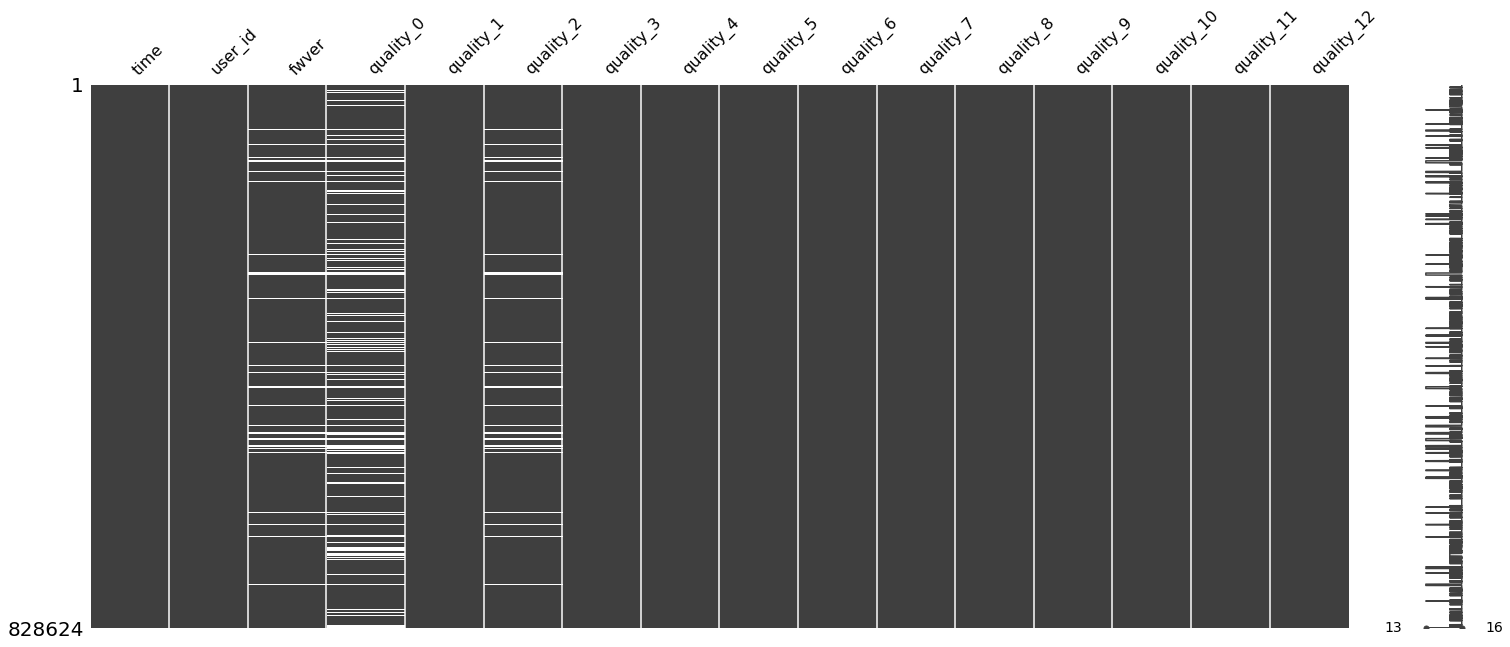

In [30]:
import missingno as msno

# Missing Values
msno.matrix(train_quality)

<AxesSubplot:>

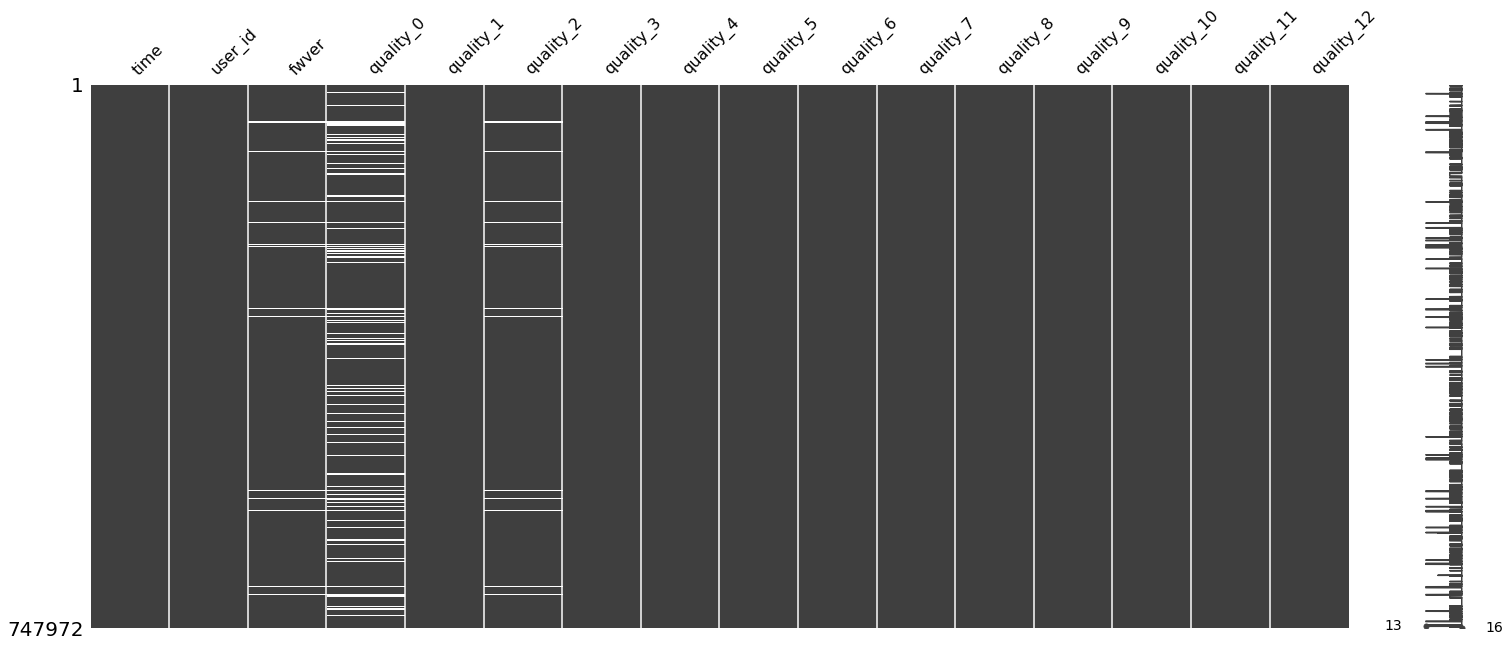

In [34]:
import missingno as msno

# Missing Values
msno.matrix(test_quality)

In [31]:
# Missing Value 확인
print("Train-set")
display( train_err.isnull().sum() )

print('=' * 80)

print("Test-set")
display( test_err.isnull().sum() )


Train-set


user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     1
dtype: int64

Test-set


user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     4
dtype: int64

In [32]:
# Missing Value 확인
print("Train-set")
display( train_quality.isnull().sum() )

print('=' * 80)

print("Test-set")
display( test_quality.isnull().sum() )


Train-set


time               0
user_id            0
fwver          40080
quality_0     144432
quality_1          0
quality_2      40113
quality_3          0
quality_4          0
quality_5         20
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

Test-set


time               0
user_id            0
fwver          22764
quality_0     106584
quality_1         11
quality_2      21115
quality_3          0
quality_4          0
quality_5         44
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

### 4. Target Variable의 분포는?

In [35]:
train_problem.head()

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


In [37]:
# Target Variable의 분포를 살펴보자
target_col = 'time'

train_problem[target_col].value_counts().sort_index()

20201101000000     1
20201101010000     3
20201101020000     3
20201101090000     1
20201101110000     3
                  ..
20201130190000    35
20201130200000    11
20201130210000     5
20201130220000    10
20201130230000     2
Name: time, Length: 488, dtype: int64

<AxesSubplot:xlabel='time', ylabel='Density'>

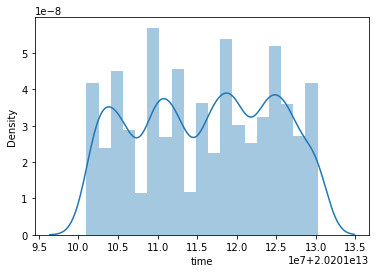

In [40]:
# Dist-plot을 그려보도록 한다.
sns.distplot( train_problem[target_col] )

<AxesSubplot:xlabel='time', ylabel='Density'>

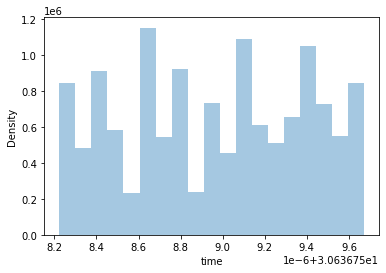

In [41]:
# log1p transformation을 적용해봐도 정규분포에 근사한 모양을 보이지 않는다.
sns.distplot( np.log1p( train_problem[target_col] ) )

### 5. 간단히 데이터 살펴보기

In [27]:
train_err.describe()

,user_id,time,errtype
count,1.655466e+07,1.655466e+07,1.655466e+07
mean,1.758495e+04,2.020112e+13,2.128030e+01
std,4.341885e+03,8.664375e+06,9.943175e+00
min,1.000000e+04,2.020103e+13,1.000000e+00
25%,1.392500e+04,2.020111e+13,1.500000e+01
50%,1.748500e+04,2.020112e+13,2.300000e+01
75%,2.122700e+04,2.020112e+13,3.100000e+01
max,2.499900e+04,2.020120e+13,4.200000e+01


In [26]:
train_quality.describe()

,time,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_6,quality_11,quality_12
count,8.286240e+05,828624.000000,684192.000000,828624.000000,788511.000000,828624.0,828624.0,828624.000000,828624.000000,828624.000000
mean,2.020112e+13,17574.678315,4.148701,-0.171782,4.751094,0.0,0.0,2.043391,-0.181638,0.045878
std,8.863638e+06,4374.113554,479.315029,0.692386,586.252469,0.0,0.0,32.695380,0.397767,0.302452
min,2.020103e+13,10000.000000,-1.000000,-1.000000,-1.000000,0.0,0.0,-1.000000,-1.000000,0.000000
25%,2.020111e+13,13685.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
50%,2.020112e+13,17597.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
75%,2.020112e+13,21423.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
max,2.020113e+13,24997.000000,157667.000000,171.000000,191859.000000,0.0,0.0,600.000000,14.000000,14.000000


In [43]:
train_problem.describe()

,user_id,time
count,5429.000000,5.429000e+03
mean,17567.540615,2.020112e+13
std,4330.245143,8.611525e+06
min,10001.000000,2.020110e+13
25%,13778.000000,2.020111e+13
50%,17616.000000,2.020112e+13
75%,21346.000000,2.020112e+13
max,24998.000000,2.020113e+13


### train_err

<AxesSubplot:>

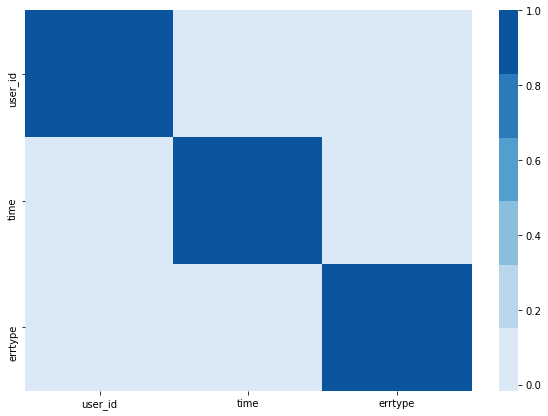

In [28]:
# 전체 데이터에 대한 상관관계 HeatMap 시각화
corr = train_err.corr()
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, cmap=cmap)

In [35]:
train_err.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      int64 
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(3), object(3)
memory usage: 757.8+ MB


### train_err

### user_id

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

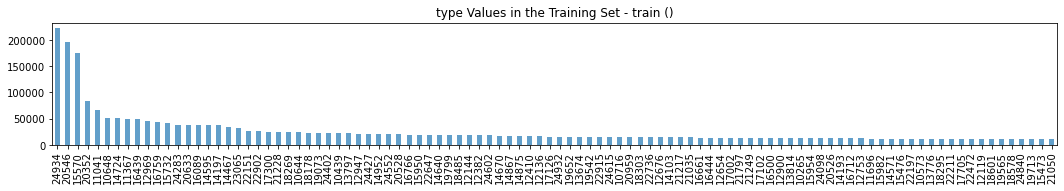

In [31]:
# user_id
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_err['user_id'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

<AxesSubplot:xlabel='user_id'>

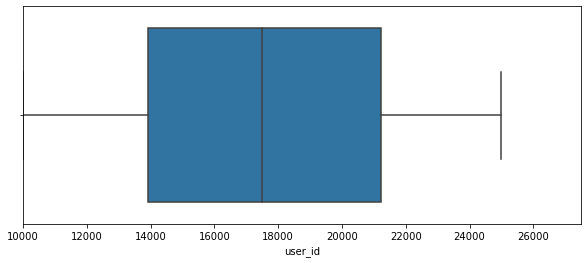

In [34]:
plt.figure(figsize=(10,4))
plt.xlim(train_err.user_id.min(), train_err.user_id.max()*1.1)
sns.boxplot(x=train_err.user_id)

### time

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

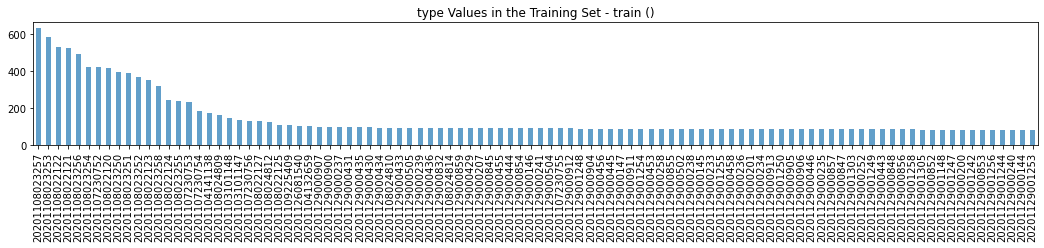

In [36]:
# time
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_err['time'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

### model_nm

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

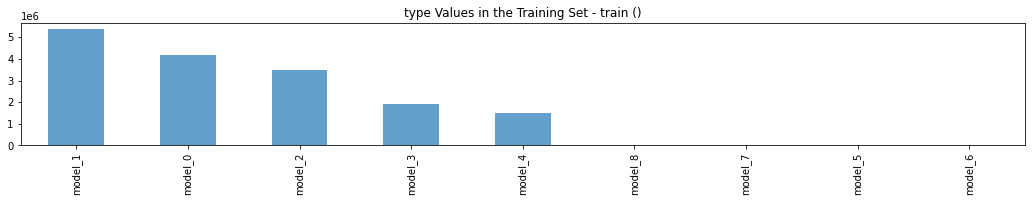

In [38]:
# model_nm
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_err['model_nm'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

### fwver

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

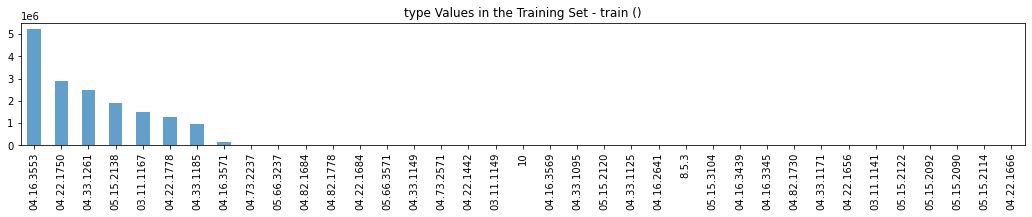

In [40]:
# fwver
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_err['fwver'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

### errtype

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

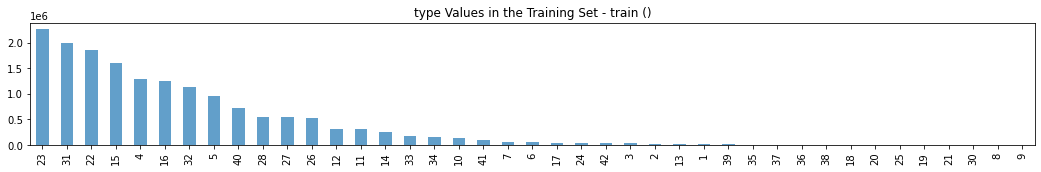

In [41]:
# errtype
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_err['errtype'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

### errcode

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

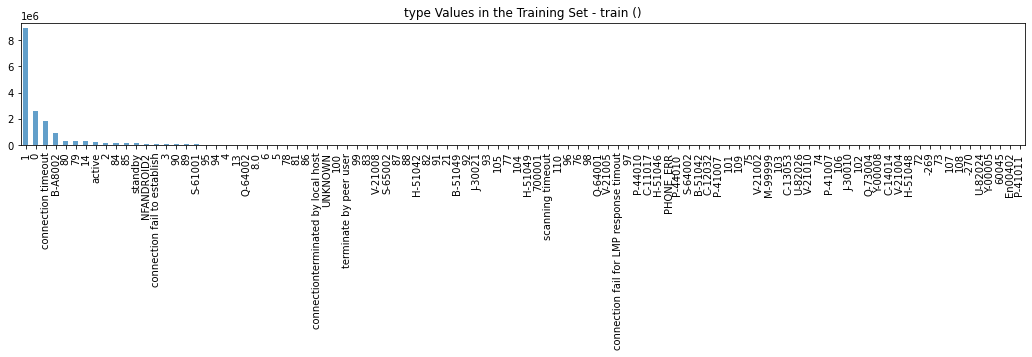

In [42]:
# errcode
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_err['errcode'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

## train_quality

In [44]:
train_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       788544 non-null  object 
 3   quality_0   684192 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   788511 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828604 non-null  object 
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  object 
 11  quality_8   828624 non-null  object 
 12  quality_9   828624 non-null  object 
 13  quality_10  828624 non-null  object 
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 101.2+ MB


<AxesSubplot:>

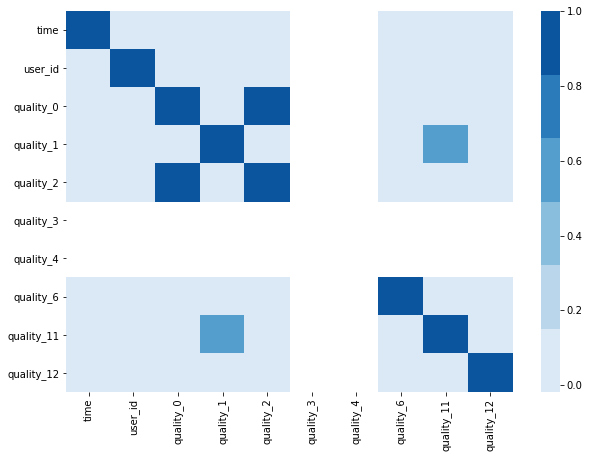

In [57]:
# 전체 데이터에 대한 상관관계 HeatMap 시각화
corr = train_quality.corr()
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, cmap=cmap)

### time

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

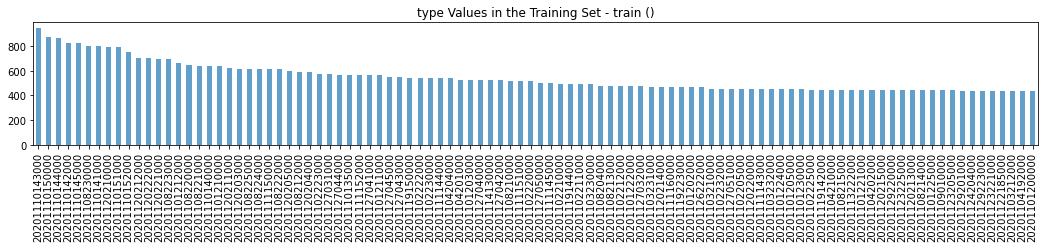

In [45]:
# time
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_quality['time'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

### user_id

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

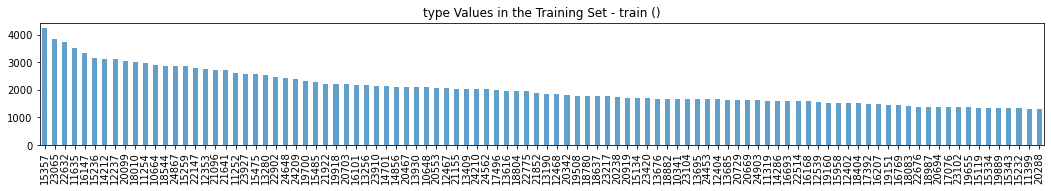

In [48]:
# user_id
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_quality['user_id'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

### fwver

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

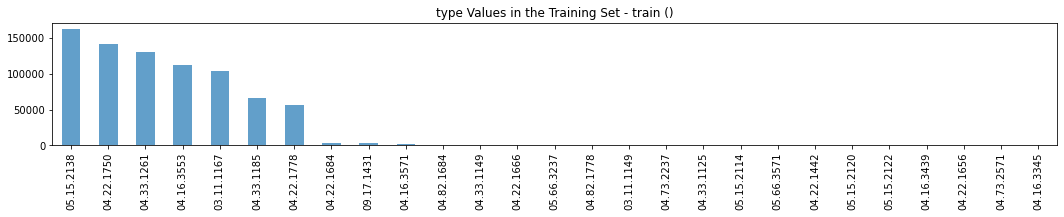

In [47]:
# fwver
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_quality['fwver'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

### quality_0

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

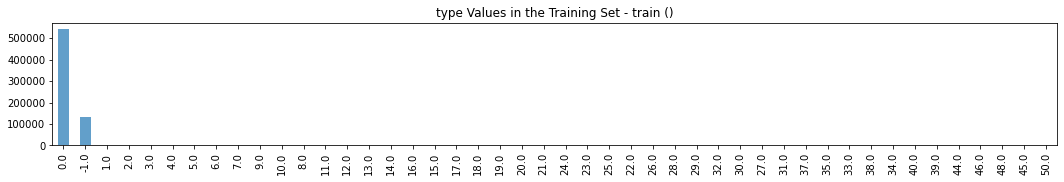

In [53]:
# fwver
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_quality['quality_0'].value_counts()[:50].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

<AxesSubplot:xlabel='quality_0'>

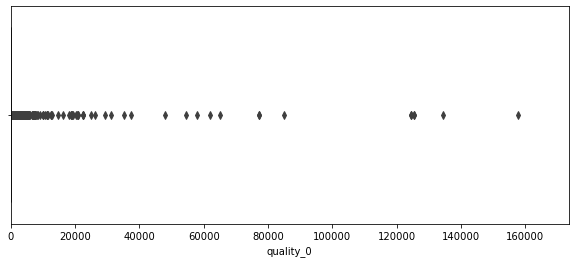

In [56]:
plt.figure(figsize=(10,4))
plt.xlim(train_quality.quality_0.min(), train_quality.quality_0.max()*1.1)
sns.boxplot(x=train_quality.quality_0)

### quality_1

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

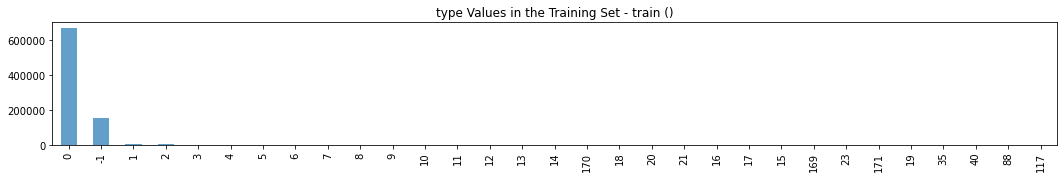

In [52]:
# quality_1
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_quality['quality_1'].value_counts()[:50].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

<AxesSubplot:xlabel='quality_1'>

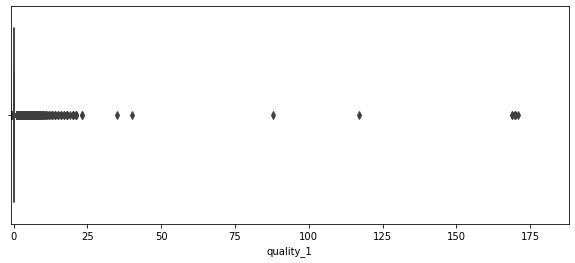

In [55]:
plt.figure(figsize=(10,4))
plt.xlim(train_quality.quality_1.min(), train_quality.quality_1.max()*1.1)
sns.boxplot(x=train_quality.quality_1)

### quality_2

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

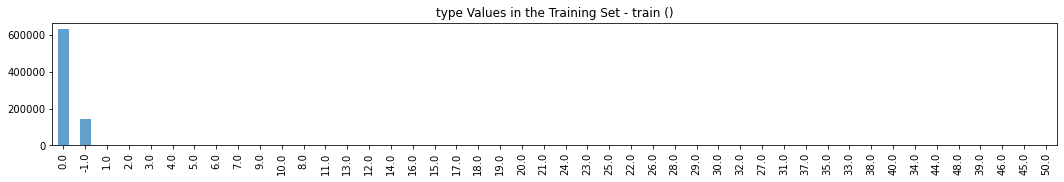

In [51]:
# quality_2
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_quality['quality_2'].value_counts()[:50].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

<AxesSubplot:xlabel='quality_2'>

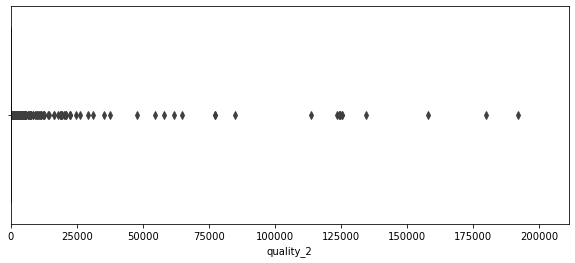

In [54]:
plt.figure(figsize=(10,4))
plt.xlim(train_quality.quality_2.min(), train_quality.quality_2.max()*1.1)
sns.boxplot(x=train_quality.quality_2)

### 6. 데이터의 특이한/주목해야할 부분은?

In [58]:
# ...